<a href="https://colab.research.google.com/github/hyxxnii/Tave-6th-Machine-Learning-Practice/blob/master/Ch08.%20Text%20Analysis/09.%20%ED%85%8D%EC%8A%A4%ED%8A%B8%20%EB%B6%84%EC%84%9D%20%EC%8B%A4%EC%8A%B5%20-%20%EC%BA%90%EA%B8%80%20Mercari%20Price%20Suggestion%20Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle competitions download -c mercari-price-suggestion-challenge

  0% 0.00/7.77M [00:00<?, ?B/s]
100% 7.77M/7.77M [00:00<00:00, 128MB/s]
  0% 0.00/170k [00:00<?, ?B/s]
100% 170k/170k [00:00<00:00, 179MB/s]
100% 34.0M/34.0M [00:00<00:00, 48.7MB/s]

 82% 61.0M/74.3M [00:00<00:00, 80.9MB/s]
100% 74.3M/74.3M [00:00<00:00, 168MB/s] 
 95% 281M/294M [00:02<00:00, 188MB/s]
100% 294M/294M [00:02<00:00, 141MB/s]


In [ ]:
!p7zip -d train.tsv.7z


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 77912192 bytes (75 MiB)

Extracting archive: train.tsv.7z
--
Path = train.tsv.7z
Type = 7z
Physical Size = 77912192
Headers Size = 122
Method = LZMA2:24
Solid = -
Blocks = 1

  0%      3% - train.tsv                  7% - train.tsv                 11% - train.tsv                 14% - train.tsv                 18% - train.tsv                 22% - train.tsv                 26% - train.tsv                 29% - train.tsv                 33% - train.tsv

## 데이터 전처리

In [ ]:
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd

mercari_df = pd.read_csv('train.tsv', sep='\t')
print(mercari_df.shape)
mercari_df.head(3)

(1482535, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


In [ ]:
print(mercari_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482531 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB
None


- brand_name 칼럼의 경우 매우 많은 Null값 가지고 있음
    - brand_name은 가격에 영향을 미치는 중요 요인으로 판단되지만, 많은 데이터가 Null로 돼 있음
- Category_name은 약 6300건의 Null 데이터 가지고 있음
- item_description의 Null값은 4건으로 미비함
- 이 Null 데이터는 적절한 문자열로 치환

Target 값인 Price 칼럼의 데이터 분포도를 살펴보자

회귀에서 Target 값의 정규분포도를 매우 중요

⇒ 왜곡돼 있을 경우 보통 로그를 씌워서 변환하면 대부분 정규분포의 형태를 가지게 됨

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


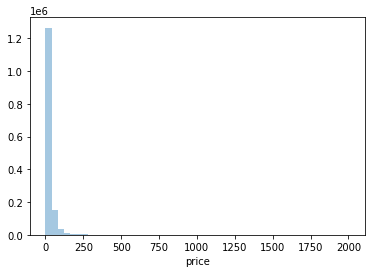

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

y_train_df = mercari_df['price']
plt.figure(figsize=(6,4))
sns.distplot(y_train_df, kde=False)

- price 값이 비교적 적은 가격을 가진 데이터 값에 왜곡돼 분포돼 있음
- Price 칼럼을 로그 값 변화한 뒤 분포도를 다시 살펴보자

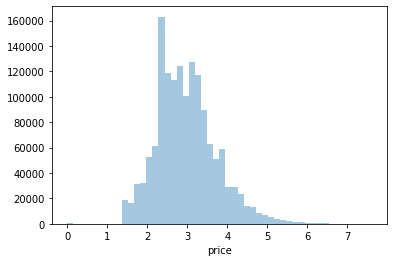

In [ ]:
import numpy as np

y_train_df = np.log1p(y_train_df)
sns.distplot(y_train_df, kde=False)

- 로그 값으로 변환하면 price 값이 비교적 정규분포에 가까운 데이터를 이루게 됨
- 데이터 세트의 price 칼럼을 원래 값에서 로그로 변한된 값으로 변경하자

In [ ]:
mercari_df['price'] = np.log1p(mercari_df['price'])
mercari_df['price'].head(3)

0    2.397895
1    3.970292
2    2.397895
Name: price, dtype: float64

다른 피처의 값도 살펴보자. shipping과 item_condition_df값의 유형은 다음과 같음

In [ ]:
print('Shipping 값 유형:\n', mercari_df['shipping'].value_counts())
print('\nitem_condition_id 값 유형:\n', mercari_df['item_condition_id'].value_counts())

Shipping 값 유형:
 0    819435
1    663100
Name: shipping, dtype: int64

item_condition_id 값 유형:
 1    640549
3    432161
2    375479
4     31962
5      2384
Name: item_condition_id, dtype: int64


- Shipping 칼럼은 배송비 유무이며, 값이 비교적 균일함
- Item_condition_id는 판매자가 제공하는 제품 상태로서 각 값이 의미하는 바는 캐글에 기재돼 있지 않아서 알 수 없지만, 1, 2, 3 값이 주를 이루고 있음

item_description 칼럼은 Null 값은 별로 없지만, description에 대한 별도 설명이 없는 경우 'No description yet'값으로 돼 있음. 이러한 값이 얼마나 있는지 알아보자

In [ ]:
boolean_cond = mercari_df['item_description'] == 'No description yet'
mercari_df[boolean_cond]['item_description'].count()

82489

- 'No description yet'의 경우도 Null과 마찬가지로 의미 있는 속성값으로는 사용될 수 없으므로 적절한 값으로 변경해야 함

category_name을 살펴보자. category_name은 '/'로 분리된 카테고리를 하나의 문자열로 나타내고 있음

가령 'Men/ Tops /T-shirts'는 대분류 'Men', 중분류 'Tops', 소분류 'T-shirts'로 나눌 수 있음

category_name은 텍스트이므로 피처 추출 시 tokenizer를 '/'로 하여 단어를 분리해 벡터화할 수도 있지만, 여기서는 category_name의 '/'를 기준으로 단어를 토큰화해 각각 별도의 피처로 저장하고 이를 이용해 알고리즘을 학습시킴

- split_cat() 함수
    - 먼저 category_name이 Null이 아닌 경우에 split('/')를 이용해 대, 중, 소분류를 분리
        - 파이썬은 문자열에 split(tokenizer문자) 함수를 호출하면 tokenizer 문자에 따라 문자열을 분리해 리스트로 반환
    - 만일 category_name이 Null일 경우에는 split() 함수가 Error가 발생하므로 이 Error를 except catch하여 대, 중, 소분류 모두 'Other Null' 값을 부여
- 대, 중, 소 칼럼은 cat_dae, cat_jung, cat_so로 부여
- *주의점*
    - 판다스의 apply lambda로 반환되는 데이터 세트가 리스트를 요소로 가지고 있는데, 이를 다시 cat_dae, cat_jung, cat_so의 DataFrame 칼럼으로 분리해야 하는 것
    - 이 부분은 zip과 *를 apply lambda 식에 적용하면 여러 개의 칼럼으로 간단하게 분리 가능

In [ ]:
# applyt lambda에서 호출되는 대, 중, 소 분할 함수 생성
# 대, 중, 소 값을 리스트로 반환

def split_cat(category_name):
  try:
    return category_name.split('/')
  except:
    return ['Other_Null', 'Other_Null', 'Other_Null']

# 위의 split_cat()을 apply lambda에서 호출해 대, 중, 소 칼럼을 mercari_df에 생성
mercari_df['cat_dae'], mercari_df['cat_jung'], mercari_df['cat_so'] = \
zip(*mercari_df['category_name'].apply(lambda x: split_cat(x)))

# 대분류만 값의 유형과 건수를 살펴보고, 중분류와 소분류는 값의 유형이 많으므로 분류 개수만 추출
print('대분류 유형: \n', mercari_df['cat_dae'].value_counts())
print('중분류 개수: \n', mercari_df['cat_jung'].nunique())
print('소분류 개수: \n', mercari_df['cat_so'].nunique())

대분류 유형: 
 Women                     664385
Beauty                    207828
Kids                      171689
Electronics               122690
Men                        93680
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30842
Sports & Outdoors          25342
Other_Null                  6327
Name: cat_dae, dtype: int64
중분류 개수: 
 114
소분류 개수: 
 871


- 대분류의 경우 Woman, Beauty, Kids 등의 분류가 매우 많음
- 중분류 유형은 114개, 소분류는 871개로 구성돼 있음

마지막으로 brand_name, category_name, item_description 칼럼의 Null 값은 일괄적으로 'Other Null'로 동일하게 변경

brand_name은 price 값 결정에 영향을 많이 줄 것으로 판단되지만, Null 값이 매우 많음

⇒ 아쉽게도 이 Null 값을 다른 값으로 변경하는 것은 적절하지 않을 것으로 판단되므로 일괄적으로 'Other_Null'로 변경

In [ ]:
mercari_df['brand_name'] = mercari_df['brand_name'].fillna(value='Other_Null')
mercari_df['category_name'] = mercari_df['category_name'].fillna(value='Other_Null')
mercari_df['item_description'] = mercari_df['item_description'].fillna(value='Other_Null') 

mercari_df.isnull().sum()

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
cat_dae              0
cat_jung             0
cat_so               0
dtype: int64

## 피처 인코딩과 피처 벡터화

Mercari Price Suggestion에 이용되는 데이터 세트는 문자열 칼럼이 많음

이 문자열 칼럼 중 레이블 또는 원-핫 인코딩을 수행하거나 피처 벡터화로 변환할 칼럼을 선별해 보자

먼저 피처를 어떤 방식으로 변환할 지 검토한 후에 추후에 일괄적으로 전체 속성의 변환 작업을 적용하겠음

Mercari Price Suggestion에서 예측 모델은 Price 값, 즉 상품 가격을 예측해야 하므로 회귀 모델을 기반으로 함

- 선형 회귀 모델과 회귀 트리 모델을 모두 적용할 예정이며, 특히 **선형 회귀의 경우 원-핫 인코딩 적용이 훨씬 선호**되므로 인코딩할 피처는 모두 원-핫 인코딩을 적용
- 피처 벡터화의 경우는 비교적 짧은 텍스트의 경우 `Count 기반의 벡터화`를, 긴 텍스트는 `TF-IDF 기반의 벡터화`를 적용

1. brand_name

In [ ]:
print('brand name의 유형 건수: ', mercari_df['brand_name'].nunique())
print('brand name sample 5건:' , mercari_df['brand_name'].value_counts()[:5])

brand name의 유형 건수:  4810
brand name sample 5건: Other_Null           632682
PINK                  54088
Nike                  54043
Victoria's Secret     48036
LuLaRoe               31024
Name: brand_name, dtype: int64


- 대부분 명료한 문자열로 돼 있음
- 별의 처 벡터화 형태로 만들 필요 없이 인코딩 변환 적용하면 됨
- 종류 4,810건으로 원-핫 인코딩으로 변환하기에 다소 많아 보이나 본 예제의 ML 모델 구축상 큰 문제는 없음

    ⇒ brand_name은 `원-핫 인코딩` 변환

In [ ]:
print('name의 종류 개수: ', mercari_df['name'].nunique())
print('name sample 10건: ', mercari_df['name'][:10])

name의 종류 개수:  1225273
name sample 10건:  0       MLB Cincinnati Reds T Shirt Size XL
1          Razer BlackWidow Chroma Keyboard
2                            AVA-VIV Blouse
3                     Leather Horse Statues
4                      24K GOLD plated rose
5          Bundled items requested for Ruie
6        Acacia pacific tides santorini top
7      Girls cheer and tumbling bundle of 7
8                     Girls Nike Pro shorts
9    Porcelain clown doll checker pants VTG
Name: name, dtype: object


- 상품명은 name 속성의 경우 종류가 매우 많음 → 무려 1,225,273가지
- 전체 데이터가 1,482,535개이므로 개별적으로 거의 고유한 상품명을 가지고 있음
- Name 속성은 유형이 매우 많고, 적은 단어 위주의 텍스트 형태로 돼 있으므로 `Count 기반으로 피처 벡터화` 변환을 적용

2.category_name
- category_name은 대, 중, 소 별로 원핫 인코딩 적용

3.shipping
- 배송비 무료여부인 shipping칼럼도 1,2,3,4,5 다섯가지 유형이므로 원핫 인코딩 적용

4.item_description

In [ ]:
pd.set_option('max_colwidth', 200)

# item_description 평균 문자열 크기
print('item_description 평균 문자열 크기:', mercari_df['item_description'].str.len().mean())

mercari_df['item_description'][:2]

item_description 평균 문자열 크기: 145.7113889385411


0                                                                                                                                                                              No description yet
1    This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.
Name: item_description, dtype: object

- 평균 문자열이 145자로 비교적 크므로 TF-IDF변환

In [ ]:
# name 속성에 대한 피처 벡터화 변환
cnt_vec = CountVectorizer()
X_name = cnt_vec.fit_transform(mercari_df.name)

# item_description에 대한 피처 벡터화 변환
tfidf_descp = TfidfVectorizer(max_features=50000, ngram_range=(1,3), stop_words='english')
X_descp = tfidf_descp.fit_transform(mercari_df['item_description'])

print('name vectorization shape:', X_name.shape)
print('item_description vectorization shape:', X_descp.shape)

name vectorization shape: (1482535, 105757)
item_description vectorization shape: (1482535, 50000)


- X_name, X_descp는 희소 행렬 형태이므로 인코딩 대상 칼럼도 희소 행렬 형태로 인코딩 적용해야함!
- 사이킷런이 제공하는 원ㅡ핫 인코딩 클래스
    - `OneHotEncoder`
    - `LabelBinarizer` : 희소 행렬 형태의 변환 지원
    (sparse_out=True로 설정)

In [ ]:
from sklearn.preprocessing import LabelBinarizer

# brand_name, item_condition_id, shipping 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_brand_name = LabelBinarizer(sparse_output=True)
X_brand = lb_brand_name.fit_transform(mercari_df['brand_name'])

lb_item_cond_id = LabelBinarizer(sparse_output=True)
X_item_cond_id = lb_item_cond_id.fit_transform(mercari_df['item_condition_id'])

lb_shipping = LabelBinarizer(sparse_output=True)
X_shipping = lb_shipping.fit_transform(mercari_df['shipping'])

# cat_dae, cat_jung, cat_so 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_cat_dae = LabelBinarizer(sparse_output=True)
X_cat_dae = lb_cat_dae.fit_transform(mercari_df['cat_dae'])

lb_cat_jung = LabelBinarizer(sparse_output=True)
X_cat_jung = lb_cat_jung.fit_transform(mercari_df['cat_jung'])

lb_cat_so = LabelBinarizer(sparse_output=True)
X_cat_so = lb_cat_so.fit_transform(mercari_df['cat_so'])

In [ ]:
print(type(X_brand), type(X_item_cond_id), type(X_shipping))
print('X_brand shape:{0}, X_item_cond_id shape:{1}'.format(X_brand.shape, X_item_cond_id.shape))
print('X_shipping shape:{0}, X_cat_dae shape:{1}'.format(X_shipping.shape, X_cat_dae.shape))
print('X_cat_jung shape:{0}, X_cat_so shape:{1}'.format(X_cat_jung.shape, X_cat_so.shape))

<class 'scipy.sparse.csr.csr_matrix'> <class 'scipy.sparse.csr.csr_matrix'> <class 'scipy.sparse.csr.csr_matrix'>
X_brand shape:(1482535, 4810), X_item_cond_id shape:(1482535, 5)
X_shipping shape:(1482535, 1), X_cat_dae shape:(1482535, 11)
X_cat_jung shape:(1482535, 114), X_cat_so shape:(1482535, 871)


- 피처 벡터화 변환한 데이터 셋과 희소 인코딩 변환된 데이터 셋을 `hstack()` 이용하여 결합
- 메모리 차지가 심하므로 모델 적용할 때마다 결합과 삭제 반복

In [ ]:
from scipy.sparse import hstack
import gc

sparse_matrix_list = (X_name, X_descp, X_brand, X_item_cond_id, \
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

# hstack 함수를 이용해 인코딩과 벡터화를 수행한 데이터 세트를 모두 결합
X_features_sparse = hstack(sparse_matrix_list).tocsr()
print(type(X_features_sparse), X_features_sparse.shape)

# 데이터 세트가 메모리를 많이 차지하므로 사용 목적이 끝났으면 바로 메모리에서 삭제
del X_features_sparse
gc.collect()

<class 'scipy.sparse.csr.csr_matrix'> (1482535, 161569)


712

## 릿지 회귀 모델 구축 및 평가

**[평가 함수 주요 로직]**

1. target칼럼은 정규분포로 **로그변환** 되어있음
2. 로그변환된 데이터로 모델은 **예측** 수행
3. 예측된 값은 다시 **지수변환** 수행해서 원상태로!
4. 원복된 데이터로 **RMSLE** 적용

In [ ]:
def rmsle(y, y_pred):
  # underflow, overflow를 막기 위해 log가 아닌 log1p로 rmsle 계산
  return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y_pred), 2)))

def evaluate_org_price(y_test, preds):
  # 원본 데이터는 log1p로 변환됐으므로 exmpm1로 원복 필요
  preds_exmpm = np.expm1(preds)
  y_test_exmpm = np.expm1(y_test)

  # rmsle로 RMSLE 값 추출
  rmsle_result = rmsle(y_test_exmpm, preds_exmpm)
  return rmsle_result

[**모델 학습/예측 함수 로직]**

1. hstack으로 희소 행렬결합
2. 학습, 평가 데이터셋 생성
3. 모델 학습 및 예측
4. 만든 데이터셋 삭제 후 예측값 반환

In [ ]:
import gc
from scipy.sparse import hstack

def model_train_predict(model, matrix_list):
  # scipy.sparse 모듈의 hstack을 이용해 희소행렬 결합
  X = hstack(matrix_list).tocsr()

  X_train, X_test, y_train, y_test = train_test_split(X, mercari_df['price'], test_size=0.2, random_state=156)

  # 모델 학습 및 예측
  model.fit(X_train, y_train)
  preds = model.predict(X_test)

  del X, X_train, X_test, y_train
  gc.collect()

  return preds, y_test

- Ridge를 이용해 회귀 예측 수행
- 수행 전 item_description 속성의 영향도 파악

In [ ]:
linear_model = Ridge(solver='lsqr', fit_intercept=False)

sparse_matrix_list = (X_name, X_brand, X_item_cond_id, \
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds, y_test = model_train_predict(model=linear_model, matrix_list = sparse_matrix_list)
print('Item Descirption을 제외했을 때 rmsle 값:', evaluate_org_price(y_test, linear_preds))

sparse_matrix_list = (X_name, X_descp, X_brand, X_item_cond_id, \
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds, y_test = model_train_predict(model=linear_model, matrix_list = sparse_matrix_list)
print('Item Descirption을 포함했을 때 rmsle 값:', evaluate_org_price(y_test, linear_preds))

Item Descirption을 제외했을 때 rmsle 값: 0.5023727038010544
Item Descirption을 포함했을 때 rmsle 값: 0.4712202487114061


## LightGBM 회귀 모델 구축과 앙상블을 이용한 최종 예측 평가


- LigthGBM이용해 회귀 수행
- 앞서 구한 릿지 모델 예측값과 앙상블로 섞어서 최종 회귀 예측값 평가

In [ ]:
from lightgbm import LGBMRegressor

sparse_matrix_list = (X_name, X_descp, X_brand, X_item_cond_id, \
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

lgbm_model = LGBMRegressor(n_estimator=200, learning_rate=0.5, num_leaves=125, random_state=156)
lgbm_preds, y_test = model_train_predict(model=lgbm_model, matrix_list=sparse_matrix_list)
print('LightGBM rmsle 값:', evaluate_org_price(y_test, lgbm_preds))

LightGBM rmsle 값: 0.465034977109834


In [ ]:
preds = lgbm_preds * 0.45 + linear_preds * 0.55
print('LightGBM과 Ridge를 ensemble한 최종 rmsle 값:' , evaluate_org_price(y_test, preds))

LightGBM과 Ridge를 ensemble한 최종 rmsle 값: 0.4544583530483535
